In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.learning_curve import validation_curve
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error
from sklearn.cluster import KMeans
import statsmodels.api as sm
import math
from scipy import stats
from scipy.stats import boxcox
from scipy.special import boxcox1p

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [3]:
df = pd.read_csv('nfl_betting_df.csv', index_col = 0)

In [4]:
df['exp_win_difference'] = df.home_exp_win_pct- df.away_exp_win_pct
df = df[df.schedule_season > 1978]

df['total_ppg'] = (df.h_ppg + df.a_ppg)
df['total_points_against'] = (df.h_papg + df.a_papg)
df['last_four_difference'] = (df.home_win_pct_last_4 - df.away_win_pct_last_4)

df[['weather_temperature', 'weather_wind_mph', 'weather_humidity']]=df[['weather_temperature', 'weather_wind_mph', 'weather_humidity']].fillna(value=np.round(df.mean(),3))
df[['over_under_line']]=df[['over_under_line']].fillna(value=(np.round(df.mean()*2)/2))

df['over_under_result'] = np.where(df['over_under_result']=='under', 0, df.over_under_result)
df['over_under_result'] = np.where(df['over_under_result']=='over', 1, df.over_under_result)
df['over_under_result'] = np.where(df['over_under_result']=='push', 2, df.over_under_result)

df = df.fillna(value = 0)

df.index = range(0, len(df))

In [5]:
reg_df = df[(df.schedule_week > 1) & (df.schedule_week < 19) & (df.schedule_season>2001)]
week5_df = df[(df.schedule_week > 4) & (df.schedule_week < 19) & (df.schedule_season>2001)]

# setting up features and targets then splitting data into train and test sets

In [6]:
target = np.array(week5_df[['point_total']])

In [7]:
features = week5_df.drop(columns=['point_total','score_home','score_away', 'team_home', 'team_away',
       'team_favorite_id','weather_detail', 'home_id', 'away_id', 'winning_team', 'losing_team','home_wins', 'home_losses',
       'home_ties', 'away_wins', 'away_losses', 'away_ties','home_points_for',
       'home_points_against', 'away_points_for', 'away_points_against',
       'h_games', 'a_games','home_exp_win_pct', 'away_exp_win_pct','home_win_pct', 'away_win_pct',
       'win_pct_diff','over_under_result','score_difference','favorite_covered'],axis=1)
feature_list = list(features.columns)
features = np.array(features)
#features.columns

In [8]:
train_features, test_features, train_target, test_target = train_test_split(features,target,test_size=.25,random_state=42)

In [9]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_target.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_target.shape)

Training Features Shape: (2332, 21)
Training Labels Shape: (2332, 1)
Testing Features Shape: (778, 21)
Testing Labels Shape: (778, 1)


In [10]:
# The baseline predictions are the over_under_lines
baseline_preds = test_features[:, feature_list.index('over_under_line')]

# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_target)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))


Average baseline error:  11.64


In [11]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_target);

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [12]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_target)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'points')


Mean Absolute Error: 11.67 points


In [13]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_target)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')


Accuracy: 66.96 %.


In [14]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: over_under_line      Importance: 0.13
Variable: h_ppg                Importance: 0.06
Variable: h_papg               Importance: 0.06
Variable: a_papg               Importance: 0.06
Variable: away_pt_diff_pg      Importance: 0.06
Variable: total_ppg            Importance: 0.06
Variable: total_points_against Importance: 0.06
Variable: weather_temperature  Importance: 0.05
Variable: weather_wind_mph     Importance: 0.05
Variable: weather_humidity     Importance: 0.05
Variable: a_ppg                Importance: 0.05
Variable: schedule_season      Importance: 0.04
Variable: schedule_week        Importance: 0.04
Variable: spread_favorite      Importance: 0.04
Variable: home_pt_diff_pg      Importance: 0.04
Variable: pt_diff_pg           Importance: 0.04
Variable: exp_win_difference   Importance: 0.04
Variable: home_win_pct_last_4  Importance: 0.02
Variable: away_win_pct_last_4  Importance: 0.02
Variable: last_four_difference Importance: 0.02
Variable: home_favorite        Importanc

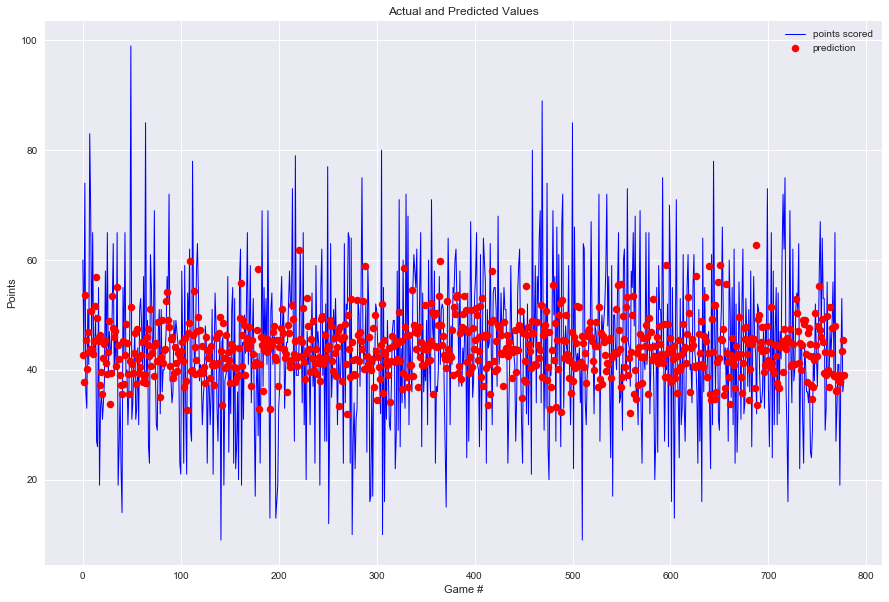

In [15]:
# Plot the actual values
plt.figure(figsize=(15,10))
plt.plot(range(0,len(test_target)), test_target[:,0], 'b-', label = 'points scored',lw=1)
# # Plot the predicted values
plt.plot(range(0,len(predictions)), predictions, 'ro', label = 'prediction', ms=7.5)
# plt.xticks(rotation = '60'); 
plt.legend()
# # Graph labels
plt.xlabel('Game #'); plt.ylabel('Points'); plt.title('Actual and Predicted Values');

In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(test_target[:,0], predictions)
print(confusion_matrix)

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [239]:
import numpy as np
from sklearn.manifold import TSNE
X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded


array([[  92.12724 , -367.05112 ],
       [-287.7084  , -477.69028 ],
       [ -18.470854,   12.796153],
       [-398.30646 ,  -97.842705]], dtype=float32)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# from matplotlib.ticker import NullFormatter
# from sklearn import manifold, datasets
# from time import time

# n_samples = 300
# n_components = 2
# (fig, subplots) = plt.subplots(3, 5, figsize=(15, 8))
# perplexities = [5, 30, 50, 100]

# X, y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)

# red = y == 0
# green = y == 1

# ax = subplots[0][0]
# ax.scatter(X[red, 0], X[red, 1], c="r")
# ax.scatter(X[green, 0], X[green, 1], c="g")
# ax.xaxis.set_major_formatter(NullFormatter())
# ax.yaxis.set_major_formatter(NullFormatter())
# plt.axis('tight')

# for i, perplexity in enumerate(perplexities):
#     ax = subplots[0][i + 1]

#     t0 = time()
#     tsne = manifold.TSNE(n_components=n_components, init='random',
#                          random_state=0, perplexity=perplexity)
#     Y = tsne.fit_transform(X)
#     t1 = time()
#     print("circles, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
#     ax.set_title("Perplexity=%d" % perplexity)
#     ax.scatter(Y[red, 0], Y[red, 1], c="r")
#     ax.scatter(Y[green, 0], Y[green, 1], c="g")
#     ax.xaxis.set_major_formatter(NullFormatter())
#     ax.yaxis.set_major_formatter(NullFormatter())
#     ax.axis('tight')

# # Another example using s-curve
# X, color = datasets.samples_generator.make_s_curve(n_samples, random_state=0)

# ax = subplots[1][0]
# ax.scatter(X[:, 0], X[:, 2], c=color, cmap=plt.cm.viridis)
# ax.xaxis.set_major_formatter(NullFormatter())
# ax.yaxis.set_major_formatter(NullFormatter())

# for i, perplexity in enumerate(perplexities):
#     ax = subplots[1][i + 1]

#     t0 = time()
#     tsne = manifold.TSNE(n_components=n_components, init='random',
#                          random_state=0, perplexity=perplexity)
#     Y = tsne.fit_transform(X)
#     t1 = time()
#     print("S-curve, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

#     ax.set_title("Perplexity=%d" % perplexity)
#     ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.viridis)
#     ax.xaxis.set_major_formatter(NullFormatter())
#     ax.yaxis.set_major_formatter(NullFormatter())
#     ax.axis('tight')


# # Another example using a 2D uniform grid
# x = np.linspace(0, 1, int(np.sqrt(n_samples)))
# xx, yy = np.meshgrid(x, x)
# X = np.hstack([
#     xx.ravel().reshape(-1, 1),
#     yy.ravel().reshape(-1, 1),
# ])
# color = xx.ravel()
# ax = subplots[2][0]
# ax.scatter(X[:, 0], X[:, 1], c=color, cmap=plt.cm.viridis)
# ax.xaxis.set_major_formatter(NullFormatter())
# ax.yaxis.set_major_formatter(NullFormatter())

# for i, perplexity in enumerate(perplexities):
#     ax = subplots[2][i + 1]

#     t0 = time()
#     tsne = manifold.TSNE(n_components=n_components, init='random',
#                          random_state=0, perplexity=perplexity)
#     Y = tsne.fit_transform(X)
#     t1 = time()
#     print("uniform grid, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

#     ax.set_title("Perplexity=%d" % perplexity)
#     ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.viridis)
#     ax.xaxis.set_major_formatter(NullFormatter())
#     ax.yaxis.set_major_formatter(NullFormatter())
#     ax.axis('tight')


# plt.show()